<a href="https://colab.research.google.com/github/StetskoSergey/algotrade/blob/main/5_par_AutoTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [ ]:
!pip install autokeras
!pip install python-binance
!pip install sweetviz
!pip install autots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 80.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.2 MB/s eta 0:00:00


In [ ]:
import time
import pandas as pd
import numpy as np
from autots import AutoTS
import autokeras as ak
import sweetviz as sv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from binance import Client

In [ ]:
KEY = "aacb9f8cb31a95dd6e15330b08d202548583ee581158c3d4c958527f444bacbc"
SECRET = "43b4a40ca1e8ba146f1c486640b0246b37dadc30d9269993dcd47c66f112c43a"
symbol = 'BTCUSDT'
client = Client(KEY, SECRET, testnet=True)

symbol_pairs = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'LTCUSDT']
num_cycles = 1
end_time = int(time.time() * 1000)  # Определение начального времени запроса

pair_dfs = {}

for pair in symbol_pairs:
    df = pd.DataFrame(columns=['Opentime', f'{pair}_Open', f'{pair}_High', f'{pair}_Low', f'{pair}_Close'])
    for i in range(num_cycles):
        futures_data = client.futures_klines(symbol=pair, interval=Client.KLINE_INTERVAL_1HOUR, limit=100, endTime=end_time)
        if not futures_data:
            break

        temp_df = pd.DataFrame(futures_data, columns=['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'Quotee', 'Number', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'Ignore'])
        if temp_df.empty:
            break

        temp_df = temp_df[['Opentime', 'Open', 'High', 'Low', 'Close']]
        temp_df.columns = ['Opentime', f'{pair}_Open', f'{pair}_High', f'{pair}_Low', f'{pair}_Close']

        df = pd.concat([df, temp_df], ignore_index=True)

        end_time = int(temp_df.Opentime[0] - 1)

        print(f'Цикл {i} для {pair}: {len(futures_data)} записей добавлено.')

        time.sleep(2)

    pair_dfs[pair] = df

# Вывод DataFrame для каждой пары
for pair, df in pair_dfs.items():
    print(f'DataFrame для {pair}:')
    print(df)
    print('\n')

Цикл 0 для BTCUSDT: 100 записей добавлено.
Цикл 0 для ETHUSDT: 100 записей добавлено.
Цикл 0 для BNBUSDT: 100 записей добавлено.
Цикл 0 для XRPUSDT: 100 записей добавлено.
Цикл 0 для LTCUSDT: 100 записей добавлено.
DataFrame для BTCUSDT:
         Opentime BTCUSDT_Open BTCUSDT_High BTCUSDT_Low BTCUSDT_Close
0   1687233600000     26615.80     26700.30    26421.90      26694.40
1   1687237200000     26694.40     26694.40    26422.00      26431.00
2   1687240800000     26601.60     26686.00    26430.30      26683.20
3   1687244400000     26555.30     26683.20    26436.00      26650.00
4   1687248000000     26650.00     26674.60    26437.10      26500.00
..            ...          ...          ...         ...           ...
95  1687575600000     30744.40     30769.00    30475.30      30713.20
96  1687579200000     30713.20     30769.00    30480.10      30693.60
97  1687582800000     30480.20     30769.00    30403.00      30700.00
98  1687586400000     30700.00     30769.00    30329.00      3

In [ ]:
# Создание пустого DataFrame для объединенных данных
combined_df = pd.DataFrame()

# Объединение данных из словаря pair_dfs в один DataFrame
for pair, df in pair_dfs.items():
    if combined_df.empty:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df.iloc[:, 1:]], axis=1)

# Вывод объединенного DataFrame
# combined_df

# Кореляция

In [ ]:
# combined_df['Opentime'] = pd.to_datetime(combined_df['Opentime'], unit='ms').dt.hour
combined_df['Opentime'] = pd.to_datetime(combined_df['Opentime'], unit='ms')
# combined_df['Opentime'] = pd.to_datetime(combined_df['Opentime'], unit='ms').dt.strftime('%H:%M:%S')
combined_df = combined_df.set_index('Opentime')
combined_df = combined_df.iloc[:, 1:].astype(float)

# Вывод обновленного DataFrame
print(combined_df.dtypes)
print(combined_df.describe())

BTCUSDT_High     float64
BTCUSDT_Low      float64
BTCUSDT_Close    float64
ETHUSDT_Open     float64
ETHUSDT_High     float64
ETHUSDT_Low      float64
ETHUSDT_Close    float64
BNBUSDT_Open     float64
BNBUSDT_High     float64
BNBUSDT_Low      float64
BNBUSDT_Close    float64
XRPUSDT_Open     float64
XRPUSDT_High     float64
XRPUSDT_Low      float64
XRPUSDT_Close    float64
LTCUSDT_Open     float64
LTCUSDT_High     float64
LTCUSDT_Low      float64
LTCUSDT_Close    float64
dtype: object
       BTCUSDT_High   BTCUSDT_Low  BTCUSDT_Close  ETHUSDT_Open  ETHUSDT_High  \
count    100.000000    100.000000     100.000000    100.000000    100.000000   
mean   28977.418000  28602.108000   28840.902000   1716.428500   1727.446100   
std     1278.483528   1248.100576    1264.734124     26.513158     27.602865   
min    26600.000000  26421.900000   26431.000000   1650.130000   1653.700000   
25%    28082.800000  27705.800000   28000.750000   1712.487500   1727.962500   
50%    28930.900000  28561.5000

In [ ]:
# Вывод объединенного DataFrame
combined_df

,BTCUSDT_High,BTCUSDT_Low,BTCUSDT_Close,ETHUSDT_Open,ETHUSDT_High,ETHUSDT_Low,ETHUSDT_Close,BNBUSDT_Open,BNBUSDT_High,BNBUSDT_Low,BNBUSDT_Close,XRPUSDT_Open,XRPUSDT_High,XRPUSDT_Low,XRPUSDT_Close,LTCUSDT_Open,LTCUSDT_High,LTCUSDT_Low,LTCUSDT_Close
Opentime,,,,,,,,,,,,,,,,,,,
2023-06-20 04:00:00,26700.3,26421.9,26694.4,1669.09,1674.99,1657.07,1660.00,250.000,250.000,240.000,250.000,0.5709,0.5709,0.4600,0.5549,90.06,90.32,90.00,90.11
2023-06-20 05:00:00,26694.4,26422.0,26431.0,1659.71,1660.00,1652.28,1653.70,245.639,251.000,240.000,240.000,0.5549,0.5549,0.5007,0.5444,90.03,100.00,89.88,90.06
2023-06-20 06:00:00,26686.0,26430.3,26683.2,1653.70,1653.70,1650.00,1650.47,240.000,250.000,240.000,240.000,0.5549,0.5549,0.5009,0.5549,90.08,90.29,90.00,90.08
2023-06-20 07:00:00,26683.2,26436.0,26650.0,1653.70,1653.70,1650.00,1653.70,240.000,250.000,239.112,242.875,0.5500,0.5713,0.5117,0.5713,90.08,100.00,88.99,90.03
2023-06-20 08:00:00,26674.6,26437.1,26500.0,1650.13,1653.70,1650.12,1651.01,247.469,250.000,239.000,239.000,0.5653,0.5759,0.4730,0.5735,90.08,90.17,89.97,90.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-24 03:00:00,30769.0,30475.3,30713.2,1720.55,1734.74,1720.53,1722.05,234.000,239.000,234.000,235.000,0.5440,0.5440,0.4610,0.5078,90.08,90.26,89.85,90.08
2023-06-24 04:00:00,30769.0,30480.1,30693.6,1734.74,1734.74,1720.53,1720.88,235.000,240.000,235.000,235.000,0.5078,0.5680,0.5078,0.5610,90.08,90.17,89.91,90.08
2023-06-24 05:00:00,30769.0,30403.0,30700.0,1720.91,1734.74,1720.88,1722.19,240.000,240.999,235.000,240.990,0.5600,0.5721,0.5078,0.5166,90.08,90.14,90.02,90.08


In [ ]:
correlation_values_low = combined_df.corrwith(combined_df['BTCUSDT_Low'], numeric_only=True)
correlation_values_high = combined_df.corrwith(combined_df['BTCUSDT_High'], numeric_only=True)

# Вывод значений корреляции
print("Корреляция с 'BTCUSDT_Low':")
print(correlation_values_low)
print("\nКорреляция с 'BTCUSDT_High':")
print(correlation_values_high)

Корреляция с 'BTCUSDT_Low':
BTCUSDT_High     0.990110
BTCUSDT_Low      1.000000
BTCUSDT_Close    0.990994
ETHUSDT_Open     0.683049
ETHUSDT_High     0.706035
ETHUSDT_Low      0.689568
ETHUSDT_Close    0.678278
BNBUSDT_Open    -0.058840
BNBUSDT_High    -0.105506
BNBUSDT_Low      0.085426
BNBUSDT_Close    0.001351
XRPUSDT_Open    -0.563354
XRPUSDT_High    -0.510156
XRPUSDT_Low     -0.457472
XRPUSDT_Close   -0.500553
LTCUSDT_Open    -0.047286
LTCUSDT_High    -0.210819
LTCUSDT_Low     -0.229444
LTCUSDT_Close   -0.031589
dtype: float64

Корреляция с 'BTCUSDT_High':
BTCUSDT_High     1.000000
BTCUSDT_Low      0.990110
BTCUSDT_Close    0.993293
ETHUSDT_Open     0.689678
ETHUSDT_High     0.714667
ETHUSDT_Low      0.701801
ETHUSDT_Close    0.693452
BNBUSDT_Open    -0.064880
BNBUSDT_High    -0.115904
BNBUSDT_Low      0.065676
BNBUSDT_Close   -0.008596
XRPUSDT_Open    -0.521639
XRPUSDT_High    -0.473104
XRPUSDT_Low     -0.431947
XRPUSDT_Close   -0.465870
LTCUSDT_Open    -0.021396
LTCUSDT_High    -

In [ ]:
my_report = sv.analyze(combined_df)
my_report.show_html()

/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Подготовка данных

In [ ]:
second_table = combined_df.loc[:, ['BTCUSDT_High', 'BTCUSDT_Low']]

# Вывод второй таблицы
# print(second_table)

In [ ]:
import statsmodels.tsa.stattools as ts
from scipy import stats

# Получаем столбец 'Close'
High_price = combined_df['BTCUSDT_High']

# Применяем тест Дики-Фуллера
result = ts.adfuller(High_price)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'  {key}, {value}')

ADF Statistic: -1.1292418425410498
p-value: 0.7032708655290985
Critical Values:
  1%, -3.498198082189098
  5%, -2.891208211860468
  10%, -2.5825959973472097


In [ ]:
df_diff = combined_df.copy()
df_diff = df_diff.diff()

In [ ]:
df_diff.iloc[1:]

,BTCUSDT_High,BTCUSDT_Low,BTCUSDT_Close,ETHUSDT_Open,ETHUSDT_High,ETHUSDT_Low,ETHUSDT_Close,BNBUSDT_Open,BNBUSDT_High,BNBUSDT_Low,BNBUSDT_Close,XRPUSDT_Open,XRPUSDT_High,XRPUSDT_Low,XRPUSDT_Close,LTCUSDT_Open,LTCUSDT_High,LTCUSDT_Low,LTCUSDT_Close
Opentime,,,,,,,,,,,,,,,,,,,
2023-06-20 05:00:00,-5.9,0.1,-263.4,-9.38,-14.99,-4.79,-6.30,-4.361,1.000,0.000,-10.000,-0.0160,-0.0160,0.0407,-0.0105,-0.03,9.68,-0.12,-0.05
2023-06-20 06:00:00,-8.4,8.3,252.2,-6.01,-6.30,-2.28,-3.23,-5.639,-1.000,0.000,0.000,0.0000,0.0000,0.0002,0.0105,0.05,-9.71,0.12,0.02
2023-06-20 07:00:00,-2.8,5.7,-33.2,0.00,0.00,0.00,3.23,0.000,0.000,-0.888,2.875,-0.0049,0.0164,0.0108,0.0164,0.00,9.71,-1.01,-0.05
2023-06-20 08:00:00,-8.6,1.1,-150.0,-3.57,0.00,0.12,-2.69,7.469,0.000,-0.112,-3.875,0.0153,0.0046,-0.0387,0.0022,0.00,-9.83,0.98,0.08
2023-06-20 09:00:00,-26.6,0.0,148.0,0.88,18.05,0.88,19.75,2.531,1.000,0.000,8.960,0.0089,0.0000,-0.0010,-0.0253,0.00,4.83,-1.97,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-24 03:00:00,24.6,72.3,-31.2,0.05,0.00,2.21,-12.69,0.000,1.000,0.000,1.000,-0.0060,-0.0060,-0.0040,-0.0362,-0.03,-0.06,2.10,0.00
2023-06-24 04:00:00,0.0,4.8,-19.6,14.19,0.00,0.00,-1.17,1.000,1.000,1.000,0.000,-0.0362,0.0240,0.0468,0.0532,0.00,-0.09,0.06,0.00
2023-06-24 05:00:00,0.0,-77.1,6.4,-13.83,0.00,0.35,1.31,5.000,0.999,0.000,5.990,0.0522,0.0041,0.0000,-0.0444,0.00,-0.03,0.11,0.00


In [ ]:
# Получаем столбец 'Close'
High_price = df_diff['BTCUSDT_High'].iloc[1:]

# Применяем тест Дики-Фуллера
result = ts.adfuller(High_price)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'  {key}, {value}')

ADF Statistic: -9.528988428279556
p-value: 2.9252396642213186e-16
Critical Values:
  1%, -3.4989097606014496
  5%, -2.891516256916761
  10%, -2.5827604414827157


In [ ]:
import plotly.graph_objects as go

# График для df_diff['BTCUSDT_High']
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df_diff.index, y=df_diff['BTCUSDT_High'], name='df_diff'))
fig1.update_layout(title='Значения столбца BTCUSDT_High в df_diff')

# График для combined_df['BTCUSDT_High']
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=combined_df.index, y=combined_df['BTCUSDT_High'], name='combined_df'))
fig2.update_layout(title='Значения столбца BTCUSDT_High в combined_df')

# Отображение интерактивных графиков
fig1.show()
fig2.show()

# AutoTs

In [ ]:
df_diff = df_diff.reset_index()
df_diff.iloc[1:]

,Opentime,BTCUSDT_High,BTCUSDT_Low,BTCUSDT_Close,ETHUSDT_Open,ETHUSDT_High,ETHUSDT_Low,ETHUSDT_Close,BNBUSDT_Open,BNBUSDT_High,BNBUSDT_Low,BNBUSDT_Close,XRPUSDT_Open,XRPUSDT_High,XRPUSDT_Low,XRPUSDT_Close,LTCUSDT_Open,LTCUSDT_High,LTCUSDT_Low,LTCUSDT_Close
1,2023-06-20 05:00:00,-5.9,0.1,-263.4,-9.38,-14.99,-4.79,-6.30,-4.361,1.000,0.000,-10.000,-0.0160,-0.0160,0.0407,-0.0105,-0.03,9.68,-0.12,-0.05
2,2023-06-20 06:00:00,-8.4,8.3,252.2,-6.01,-6.30,-2.28,-3.23,-5.639,-1.000,0.000,0.000,0.0000,0.0000,0.0002,0.0105,0.05,-9.71,0.12,0.02
3,2023-06-20 07:00:00,-2.8,5.7,-33.2,0.00,0.00,0.00,3.23,0.000,0.000,-0.888,2.875,-0.0049,0.0164,0.0108,0.0164,0.00,9.71,-1.01,-0.05
4,2023-06-20 08:00:00,-8.6,1.1,-150.0,-3.57,0.00,0.12,-2.69,7.469,0.000,-0.112,-3.875,0.0153,0.0046,-0.0387,0.0022,0.00,-9.83,0.98,0.08
5,2023-06-20 09:00:00,-26.6,0.0,148.0,0.88,18.05,0.88,19.75,2.531,1.000,0.000,8.960,0.0089,0.0000,-0.0010,-0.0253,0.00,4.83,-1.97,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-06-24 03:00:00,24.6,72.3,-31.2,0.05,0.00,2.21,-12.69,0.000,1.000,0.000,1.000,-0.0060,-0.0060,-0.0040,-0.0362,-0.03,-0.06,2.10,0.00
96,2023-06-24 04:00:00,0.0,4.8,-19.6,14.19,0.00,0.00,-1.17,1.000,1.000,1.000,0.000,-0.0362,0.0240,0.0468,0.0532,0.00,-0.09,0.06,0.00
97,2023-06-24 05:00:00,0.0,-77.1,6.4,-13.83,0.00,0.35,1.31,5.000,0.999,0.000,5.990,0.0522,0.0041,0.0000,-0.0444,0.00,-0.03,0.11,0.00
98,2023-06-24 06:00:00,0.0,-74.0,-54.3,1.28,0.00,1.26,-0.01,-5.000,0.000,0.000,-1.990,-0.0434,-0.0041,0.0000,0.0484,-0.05,6.86,-2.65,-0.05


In [ ]:
import copy

df = copy.copy(df_diff[:980])

# Вывод нового DataFrame
df

,Opentime,BTCUSDT_High,BTCUSDT_Low,BTCUSDT_Close,ETHUSDT_Open,ETHUSDT_High,ETHUSDT_Low,ETHUSDT_Close,BNBUSDT_Open,BNBUSDT_High,BNBUSDT_Low,BNBUSDT_Close,XRPUSDT_Open,XRPUSDT_High,XRPUSDT_Low,XRPUSDT_Close,LTCUSDT_Open,LTCUSDT_High,LTCUSDT_Low,LTCUSDT_Close
0,2023-06-20 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-20 05:00:00,-5.9,0.1,-263.4,-9.38,-14.99,-4.79,-6.30,-4.361,1.000,0.000,-10.000,-0.0160,-0.0160,0.0407,-0.0105,-0.03,9.68,-0.12,-0.05
2,2023-06-20 06:00:00,-8.4,8.3,252.2,-6.01,-6.30,-2.28,-3.23,-5.639,-1.000,0.000,0.000,0.0000,0.0000,0.0002,0.0105,0.05,-9.71,0.12,0.02
3,2023-06-20 07:00:00,-2.8,5.7,-33.2,0.00,0.00,0.00,3.23,0.000,0.000,-0.888,2.875,-0.0049,0.0164,0.0108,0.0164,0.00,9.71,-1.01,-0.05
4,2023-06-20 08:00:00,-8.6,1.1,-150.0,-3.57,0.00,0.12,-2.69,7.469,0.000,-0.112,-3.875,0.0153,0.0046,-0.0387,0.0022,0.00,-9.83,0.98,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-06-24 03:00:00,24.6,72.3,-31.2,0.05,0.00,2.21,-12.69,0.000,1.000,0.000,1.000,-0.0060,-0.0060,-0.0040,-0.0362,-0.03,-0.06,2.10,0.00
96,2023-06-24 04:00:00,0.0,4.8,-19.6,14.19,0.00,0.00,-1.17,1.000,1.000,1.000,0.000,-0.0362,0.0240,0.0468,0.0532,0.00,-0.09,0.06,0.00
97,2023-06-24 05:00:00,0.0,-77.1,6.4,-13.83,0.00,0.35,1.31,5.000,0.999,0.000,5.990,0.0522,0.0041,0.0000,-0.0444,0.00,-0.03,0.11,0.00
98,2023-06-24 06:00:00,0.0,-74.0,-54.3,1.28,0.00,1.26,-0.01,-5.000,0.000,0.000,-1.990,-0.0434,-0.0041,0.0000,0.0484,-0.05,6.86,-2.65,-0.05


В AutoTS доступны следующие параметры:

forecast_length (int): Длина прогноза. Определяет количество будущих периодов, для которых требуется сделать прогноз. Например, если forecast_length=7, то будет сделан прогноз на 7 будущих периодов.

frequency (str): Частота данных. Определяет периодичность данных, например, 'D' для ежедневных данных или 'H' для часовых данных. Если задано значение 'infer', частота будет автоматически определена на основе данных.

prediction_interval (float): Доверительный интервал для прогнозирования. Определяет долю вероятности, в которую должен попасть прогноз. Например, prediction_interval=0.9 означает 90% доверительный интервал.

ensemble (str или None): Метод ансамбля моделей. Определяет, как будет сформирован прогноз из нескольких моделей. Допустимые значения: 'simple' (простое среднее), 'weighted' (взвешенное среднее), 'bestn' (лучшие N моделей), None (отключить ансамбль).

model_list (str): Список моделей, которые будут использоваться при прогнозировании. Определяет, какие модели будут включены в процесс автоматического выбора моделей. Допустимые значения: 'fast' (быстрый список моделей), 'superfast' (сверхбыстрый список моделей), 'default' (стандартный список моделей).

transformer_list (str): Список трансформеров, которые будут использоваться при обработке данных. Определяет, какие трансформеры будут включены в процесс автоматического выбора трансформеров. Допустимые значения: 'fast' (быстрый список трансформеров), 'superfast' (сверхбыстрый список трансформеров).

drop_most_recent (int): Количество последних наблюдений, которые нужно исключить из обучающего набора данных. Это может быть полезно, если в данных есть аномалии или выбросы, которые могут негативно повлиять на модель.

max_generations (int): Максимальное количество поколений для генетического алгоритма. Определяет количество итераций для поиска лучшей модели и параметров.

num_validations (int): Количество валидаций, используемых для оценки моделей. Чем больше валидаций, тем более надежной

In [ ]:
# Создание модели AutoTS
model_High = AutoTS(
    forecast_length=3,
    frequency='infer',
    ensemble='bestn',
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards")

# Оставляем только столбец 'Low' в DataFrame
df_High = df['BTCUSDT_High']

# Обучение модели
model_High = model_High.fit(df_diff, date_col= "Opentime", value_col='BTCUSDT_High')

Inferred frequency is: H
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Template Eval Error: Exception('Transformer SinTrend failed on fit') in model 1 in generation 0: AverageValueNaive
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model DatepartRegression in generation 0 of 4
Model Number: 5 with model DatepartRegression in generation 0 of 4
Model Number: 6 with model DatepartRegression in generation 0 of 4


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 6 in generation 0: DatepartRegression
Model Number: 7 with model DatepartRegression in generation 0 of 4
Epoch 1/50
3/3 [==============================] - 11s 11ms/step - loss: 0.3632
Epoch 2/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3644
Epoch 3/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3612
Epoch 4/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3624
Epoch 5/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3598
Epoch 6/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3612
Epoch 7/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3629
Epoch 8/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3634
Epoch 9/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3593
Epoch 10/50
3/3 [==============================] - 0s 8ms/step - loss: 0.3586
Epoch 11/50
3/3 [============

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Template Eval Error: Exception('Transformer SinTrend failed on fit') in model 139 in generation 0: AverageValueNaive
Model Number: 140 with model RRVAR in generation 0 of 4
Model Number: 141 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 141 in generation 0: VAR
Model Number: 142 with model MetricMotif in generation 0 of 4
Model Number: 143 with model WindowRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 143 in generation 0: WindowRegression
Model Number: 144 with model GLS in generation 0 of 4
Model Number: 145 with model SeasonalityMotif in generation 0 of 4
Model Number: 146 with model DatepartRegression in generation 0 of 4
New Generation: 1 of 4
Model Number: 147 with model AverageValueNaive in generation 1 of 4
Model Number: 148 with model AverageValueNaive in generation 1 of 4
Model Number: 149 with model GLS in generation 1 of 4
Model 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 244 with model NVAR in generation 1 of 4
Model Number: 245 with model MetricMotif in generation 1 of 4
Model Number: 246 with model AverageValueNaive in generation 1 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 246 in generation 1: AverageValueNaive
Model Number: 247 with model ETS in generation 1 of 4
Model Number: 248 with model ConstantNaive in generation 1 of 4
Model Number: 249 with model LastValueNaive in generation 1 of 4
Model Number: 250 with model MetricMotif in generation 1 of 4
Model Number: 251 with model KalmanStateSpace in generation 1 of 4
New Generation: 2 of 4
Model Number: 252 with model KalmanStateSpace in generation 2 of 4
Model Number: 253 with model DatepartRegression in generation 2 of 4
Model Number: 254 with model KalmanStateSpace in generation 2 of 4
Model Number: 255 with model LastValueNaive in generation 2 of 4
Model Number: 256 with model RRVAR in generation 2 of 4
Model Number: 257 with m

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 275 with model DatepartRegression in generation 2 of 4
Epoch 1/50
2/2 [==============================] - 5s 16ms/step - loss: 2.6602
Epoch 2/50
2/2 [==============================] - 0s 10ms/step - loss: 2.6553
Epoch 3/50
2/2 [==============================] - 0s 9ms/step - loss: 2.6430
Epoch 4/50
2/2 [==============================] - 0s 11ms/step - loss: 2.6064
Epoch 5/50
2/2 [==============================] - 0s 9ms/step - loss: 2.5999
Epoch 6/50
2/2 [==============================] - 0s 10ms/step - loss: 2.6054
Epoch 7/50
2/2 [==============================] - 0s 10ms/step - loss: 2.5878
Epoch 8/50
2/2 [==============================] - 0s 9ms/step - loss: 2.5653
Epoch 9/50
2/2 [==============================] - 0s 10ms/step - loss: 2.5721
Epoch 10/50
2/2 [==============================] - 0s 10ms/step - loss: 2.5546
Epoch 11/50
2/2 [==============================] - 0s 10ms/step - loss: 2.5607
Epoch 12/50
2/2 [==============================] - 0s 15ms/step - loss: 2.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 288 with model KalmanStateSpace in generation 2 of 4
Model Number: 289 with model LastValueNaive in generation 2 of 4
Model Number: 290 with model MetricMotif in generation 2 of 4
Model Number: 291 with model SeasonalNaive in generation 2 of 4
Model Number: 292 with model RRVAR in generation 2 of 4
Model Number: 293 with model UnivariateMotif in generation 2 of 4
Model Number: 294 with model UnivariateMotif in generation 2 of 4
Model Number: 295 with model RRVAR in generation 2 of 4
Model Number: 296 with model AverageValueNaive in generation 2 of 4
Model Number: 297 with model SectionalMotif in generation 2 of 4
Model Number: 298 with model LastValueNaive in generation 2 of 4
Model Number: 299 with model UnivariateMotif in generation 2 of 4
Model Number: 300 with model KalmanStateSpace in generation 2 of 4
Model Number: 301 with model SeasonalNaive in generation 2 of 4
Model Number: 302 with model SeasonalityMotif in generation 2 of 4
Model Number: 303 with model GLM in 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 340 with model ConstantNaive in generation 2 of 4
Model Number: 341 with model ETS in generation 2 of 4
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on BTCUSDT_High with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 342 with model NVAR in generation 2 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 342 in generation 2: NVAR
Model Number: 343 with model MetricMotif in generation 2 of 4
Model Number: 344 with model RRVAR in generation 2 of 4
Model Number: 345 with model NVAR in generation 2 of 4
Model Number: 346 with model NVAR in generation 2 of 4
Model Number: 347 with model GLM in generation 2 of 4
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 347 in generation 2: GLM
Model Number: 348 with model RRVAR in generation 2 of 4
Model Number:

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Model Number: 438 with model WindowRegression in generation 3 of 4
Model Number: 439 with model GLS in generation 3 of 4
Model Number: 440 with model LastValueNaive in generation 3 of 4
Model Number: 441 with model ETS in generation 3 of 4
Model Number: 442 with model SeasonalityMotif in generation 3 of 4
Model Number: 443 with model NVAR in generation 3 of 4
Model Number: 444 with model UnivariateMotif in generation 3 of 4
Model Number: 445 with model GLS in generation 3 of 4
Model Number: 446 with model NVAR in generation 3 of 4
Model Number: 447 with model GLS in generation 3 of 4
Model Number: 448 with model AverageValueNaive in generation 3 of 4
Model Number: 449 with model GLS in generation 3 of 4
Model Number: 450 with model GLM in generation 3 of 4
Template Eval Error: FloatingPointError('underflow encountered in exp') in model 450 in generation 3: GLM
Model Number: 451 with model DatepartRegression in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' bu

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Epoch 1/50
3/3 [==============================] - 5s 48ms/step - loss: 349021664.0000
Epoch 2/50
3/3 [==============================] - 0s 43ms/step - loss: 760302400.0000
Epoch 3/50
3/3 [==============================] - 0s 36ms/step - loss: 536866912.0000
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 115738936.0000
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 624897216.0000
Epoch 6/50
3/3 [==============================] - 0s 21ms/step - loss: 774358272.0000
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 381443712.0000
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 120028768.0000
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 246289536.0000
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 461582784.0000
Epoch 11/50
3/3 [==============================] - 0s 22ms/step - loss: 391367360.0000
Epoch 12/50
3/3 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Template Eval Error: FloatingPointError('overflow encountered in exp') in model 470 in generation 4: GLM
Model Number: 471 with model SeasonalNaive in generation 4 of 4
Model Number: 472 with model GLS in generation 4 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 472 in generation 4: GLS
Model Number: 473 with model RRVAR in generation 4 of 4
Model Number: 474 with model SeasonalityMotif in generation 4 of 4
Model Number: 475 with model SeasonalNaive in generation 4 of 4
Model Number: 476 with model RRVAR in generation 4 of 4
Model Number: 477 with model GLS in generation 4 of 4
Model Number: 478 with model GLS in generation 4 of 4
Model Number: 479 with model SeasonalityMotif in generation 4 of 4
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 479 in generation 4: SeasonalityMotif
Model Number: 480 with model GLM in generation 4 of 4
Template Eval Error: ValueError('regression_type=user and no

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 497 with model ETS in generation 4 of 4
Model Number: 498 with model SeasonalityMotif in generation 4 of 4
Model Number: 499 with model WindowRegression in generation 4 of 4
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requir

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py:494: UserWarning:

One or more samples have no neighbors within specified radius; predicting NaN.



Model Number: 511 with model SeasonalNaive in generation 4 of 4
Model Number: 512 with model SeasonalityMotif in generation 4 of 4
Model Number: 513 with model LastValueNaive in generation 4 of 4
Model Number: 514 with model GLM in generation 4 of 4
Model Number: 515 with model MAR in generation 4 of 4
Model Number: 516 with model GLS in generation 4 of 4
Model Number: 517 with model MetricMotif in generation 4 of 4
Model Number: 518 with model MetricMotif in generation 4 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 518 in generation 4: MetricMotif
Model Number: 519 with model RRVAR in generation 4 of 4
Model Number: 520 with model SeasonalityMotif in generation 4 of 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 520 in generation 4: SeasonalityMotif
Model Number: 521 with model NVAR in generation 4 of 4
Model Number: 522 with model AverageValueNaive in generation 4 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 522 in generation 4: AverageValueNaive
Model Number: 523 with model NVAR in generation 4 of 4
Model Number: 524 with model DatepartRegression in generation 4 of 4
Model Number: 525 with model MAR in generation 4 of 4
Model Number: 526 with model ConstantNaive in generation 4 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 526 in generation 4: ConstantNaive
Model Number: 527 with model SectionalMotif in generation 4 of 4
Model Number: 528 with model DatepartRegression in generation 4 of 4
Model Number: 529 with model SeasonalityMotif in generation 4 of 4
Template Eval Error: ValueError('window sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 541 with model SeasonalityMotif in generation 4 of 4
Model Number: 542 with model KalmanStateSpace in generation 4 of 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 543 with model DatepartRegression in generation 4 of 4
Model Number: 544 with model DatepartRegression in generation 4 of 4
Model Number: 545 with model KalmanStateSpace in generation 4 of 4
Model Number: 546 with model AverageValueNaive in generation 4 of 4
Model Number: 547 with model KalmanStateSpace in generation 4 of 4
Model Number: 548 with model SeasonalityMotif in generation 4 of 4
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 548 in generation 4: SeasonalityMotif
Model Number: 549 with model NVAR in generation 4 of 4
Model Number: 550 with model MetricMotif in generation 4 of 4
Model Number: 551 with model UnivariateMotif in generation 4 of 4
Template Eval Error: Exception('Transformer SinTrend failed on fit') in model 551 in generation 4: UnivariateMotif
Model Number: 552 with model DatepartRegression in generation 4 of 4
Model Number: 553 with model GLM in generation 4 of 4
Template Eval Error: Exception('Trans

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 565 with model SeasonalityMotif in generation 4 of 4
Model Number: 566 with model GLS in generation 4 of 4
Template Eval Error: FloatingPointError('invalid value encountered in true_divide') in model 566 in generation 4: GLS
Ensembling Error: KeyError('TotalRuntime'): Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'TotalRuntime'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



8 - DatepartRegression with avg smape 199.18: 
Model Number: 9 of 85 with model DatepartRegression for Validation 1
9 - DatepartRegression with avg smape 199.17: 
Model Number: 10 of 85 with model GLS for Validation 1
10 - GLS with avg smape 199.14: 
Model Number: 11 of 85 with model ETS for Validation 1
11 - ETS with avg smape 199.94: 
Model Number: 12 of 85 with model RRVAR for Validation 1
12 - RRVAR with avg smape 198.93: 
Model Number: 13 of 85 with model GLS for Validation 1
13 - GLS with avg smape 123.01: 
Model Number: 14 of 85 with model RRVAR for Validation 1
14 - RRVAR with avg smape 197.35: 
Model Number: 15 of 85 with model RRVAR for Validation 1
15 - RRVAR with avg smape 197.35: 
Model Number: 16 of 85 with model SeasonalNaive for Validation 1
📈 16 - SeasonalNaive with avg smape 81.54: 
Model Number: 17 of 85 with model GLS for Validation 1
17 - GLS with avg smape 124.01: 
Model Number: 18 of 85 with model GLS for Validation 1
18 - GLS with avg smape 158.27: 
Model Number

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.6157e-24): result may not be accurate.



34 - KalmanStateSpace with avg smape 89.34: 
Model Number: 35 of 85 with model KalmanStateSpace for Validation 1
35 - KalmanStateSpace with avg smape 116.67: 
Model Number: 36 of 85 with model GLM for Validation 1
36 - GLM with avg smape 91.8: 
Model Number: 37 of 85 with model RRVAR for Validation 1
37 - RRVAR with avg smape 195.39: 
Model Number: 38 of 85 with model AverageValueNaive for Validation 1
38 - AverageValueNaive with avg smape 190.41: 
Model Number: 39 of 85 with model LastValueNaive for Validation 1
39 - LastValueNaive with avg smape 104.02: 
Model Number: 40 of 85 with model SeasonalNaive for Validation 1
📈 40 - SeasonalNaive with avg smape 77.8: 
Model Number: 41 of 85 with model MetricMotif for Validation 1
41 - MetricMotif with avg smape 141.06: 
Model Number: 42 of 85 with model MetricMotif for Validation 1
42 - MetricMotif with avg smape 170.59: 
Model Number: 43 of 85 with model ConstantNaive for Validation 1
43 - ConstantNaive with avg smape 173.57: 
Model Number:

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.6157e-24): result may not be accurate.



46 - RRVAR with avg smape 106.56: 
Model Number: 47 of 85 with model RRVAR for Validation 1
47 - RRVAR with avg smape 115.79: 
Model Number: 48 of 85 with model MetricMotif for Validation 1
48 - MetricMotif with avg smape 120.52: 
Model Number: 49 of 85 with model LastValueNaive for Validation 1
49 - LastValueNaive with avg smape 95.47: 
Model Number: 50 of 85 with model SeasonalityMotif for Validation 1
50 - SeasonalityMotif with avg smape 111.33: 
Model Number: 51 of 85 with model SeasonalityMotif for Validation 1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.6157e-24): result may not be accurate.




📈 51 - SeasonalityMotif with avg smape 73.19: 
Model Number: 52 of 85 with model SeasonalNaive for Validation 1
52 - SeasonalNaive with avg smape 103.08: 
Model Number: 53 of 85 with model UnivariateMotif for Validation 1
53 - UnivariateMotif with avg smape 188.57: 
Model Number: 54 of 85 with model LastValueNaive for Validation 1
54 - LastValueNaive with avg smape 116.96: 
Model Number: 55 of 85 with model NVAR for Validation 1
55 - NVAR with avg smape 105.31: 
Model Number: 56 of 85 with model NVAR for Validation 1
56 - NVAR with avg smape 152.6: 
Model Number: 57 of 85 with model ETS for Validation 1
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on BTCUSDT_High with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
57 - ETS with avg smape 118.44: 
Model Number: 58 of 85 with model LastValueNaive for Validation 1
58 - LastValueNaive with avg smape 92.24: 
Mo

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.6157e-24): result may not be accurate.



65 - KalmanStateSpace with avg smape 150.5: 
Model Number: 66 of 85 with model KalmanStateSpace for Validation 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.6157e-24): result may not be accurate.



66 - KalmanStateSpace with avg smape 148.45: 
Model Number: 67 of 85 with model NVAR for Validation 1
67 - NVAR with avg smape 101.34: 
Model Number: 68 of 85 with model AverageValueNaive for Validation 1
68 - AverageValueNaive with avg smape 99.02: 
Model Number: 69 of 85 with model ConstantNaive for Validation 1
69 - ConstantNaive with avg smape 141.91: 
Model Number: 70 of 85 with model KalmanStateSpace for Validation 1
70 - KalmanStateSpace with avg smape 104.73: 
Model Number: 71 of 85 with model SeasonalNaive for Validation 1
71 - SeasonalNaive with avg smape 192.87: 
Model Number: 72 of 85 with model SeasonalNaive for Validation 1
72 - SeasonalNaive with avg smape 98.65: 
Model Number: 73 of 85 with model SectionalMotif for Validation 1
73 - SectionalMotif with avg smape 88.51: 
Model Number: 74 of 85 with model SeasonalNaive for Validation 1
74 - SeasonalNaive with avg smape 157.73: 
Model Number: 75 of 85 with model UnivariateMotif for Validation 1
75 - UnivariateMotif with av

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




Model Number: 8 of 85 with model DatepartRegression for Validation 2
8 - DatepartRegression with avg smape 200.0: 
Model Number: 9 of 85 with model DatepartRegression for Validation 2
9 - DatepartRegression with avg smape 200.0: 
Model Number: 10 of 85 with model GLS for Validation 2
10 - GLS with avg smape 200.0: 
Model Number: 11 of 85 with model ETS for Validation 2
11 - ETS with avg smape 199.56: 
Model Number: 12 of 85 with model RRVAR for Validation 2
12 - RRVAR with avg smape 198.58: 
Model Number: 13 of 85 with model GLS for Validation 2
13 - GLS with avg smape 160.3: 
Model Number: 14 of 85 with model RRVAR for Validation 2
14 - RRVAR with avg smape 196.73: 
Model Number: 15 of 85 with model RRVAR for Validation 2
15 - RRVAR with avg smape 196.73: 
Model Number: 16 of 85 with model SeasonalNaive for Validation 2
16 - SeasonalNaive with avg smape 157.04: 
Model Number: 17 of 85 with model GLS for Validation 2
17 - GLS with avg smape 159.86: 
Model Number: 18 of 85 with model G

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.85651e-24): result may not be accurate.



34 - KalmanStateSpace with avg smape 184.51: 
Model Number: 35 of 85 with model KalmanStateSpace for Validation 2
35 - KalmanStateSpace with avg smape 140.55: 
Model Number: 36 of 85 with model GLM for Validation 2
36 - GLM with avg smape 191.38: 
Model Number: 37 of 85 with model RRVAR for Validation 2
37 - RRVAR with avg smape 199.4: 
Model Number: 38 of 85 with model AverageValueNaive for Validation 2
38 - AverageValueNaive with avg smape 132.55: 
Model Number: 39 of 85 with model LastValueNaive for Validation 2
39 - LastValueNaive with avg smape 141.85: 
Model Number: 40 of 85 with model SeasonalNaive for Validation 2
40 - SeasonalNaive with avg smape 161.79: 
Model Number: 41 of 85 with model MetricMotif for Validation 2
41 - MetricMotif with avg smape 127.85: 
Model Number: 42 of 85 with model MetricMotif for Validation 2
42 - MetricMotif with avg smape 200.0: 
Model Number: 43 of 85 with model ConstantNaive for Validation 2
43 - ConstantNaive with avg smape 150.56: 
Model Number

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.85651e-24): result may not be accurate.



Model Number: 47 of 85 with model RRVAR for Validation 2
47 - RRVAR with avg smape 143.8: 
Model Number: 48 of 85 with model MetricMotif for Validation 2
48 - MetricMotif with avg smape 136.88: 
Model Number: 49 of 85 with model LastValueNaive for Validation 2
49 - LastValueNaive with avg smape 147.53: 
Model Number: 50 of 85 with model SeasonalityMotif for Validation 2
50 - SeasonalityMotif with avg smape 140.77: 
Model Number: 51 of 85 with model SeasonalityMotif for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.85651e-24): result may not be accurate.



51 - SeasonalityMotif with avg smape 135.13: 
Model Number: 52 of 85 with model SeasonalNaive for Validation 2
52 - SeasonalNaive with avg smape 194.93: 
Model Number: 53 of 85 with model UnivariateMotif for Validation 2
53 - UnivariateMotif with avg smape 168.83: 
Model Number: 54 of 85 with model LastValueNaive for Validation 2
54 - LastValueNaive with avg smape 146.32: 
Model Number: 55 of 85 with model NVAR for Validation 2
55 - NVAR with avg smape 143.88: 
Model Number: 56 of 85 with model NVAR for Validation 2
56 - NVAR with avg smape 180.82: 
Model Number: 57 of 85 with model ETS for Validation 2
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on BTCUSDT_High with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
57 - ETS with avg smape 146.81: 
Model Number: 58 of 85 with model LastValueNaive for Validation 2
58 - LastValueNaive with avg smape 146.39: 
Mo

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.85651e-24): result may not be accurate.



65 - KalmanStateSpace with avg smape 134.82: 
Model Number: 66 of 85 with model KalmanStateSpace for Validation 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.85651e-24): result may not be accurate.



66 - KalmanStateSpace with avg smape 134.49: 
Model Number: 67 of 85 with model NVAR for Validation 2
67 - NVAR with avg smape 131.08: 
Model Number: 68 of 85 with model AverageValueNaive for Validation 2
68 - AverageValueNaive with avg smape 129.14: 
Model Number: 69 of 85 with model ConstantNaive for Validation 2
69 - ConstantNaive with avg smape 194.52: 
Model Number: 70 of 85 with model KalmanStateSpace for Validation 2
70 - KalmanStateSpace with avg smape 149.16: 
Model Number: 71 of 85 with model SeasonalNaive for Validation 2
71 - SeasonalNaive with avg smape 139.17: 
Model Number: 72 of 85 with model SeasonalNaive for Validation 2
72 - SeasonalNaive with avg smape 131.87: 
Model Number: 73 of 85 with model SectionalMotif for Validation 2
73 - SectionalMotif with avg smape 174.91: 
Model Number: 74 of 85 with model SeasonalNaive for Validation 2
74 - SeasonalNaive with avg smape 149.27: 
Model Number: 75 of 85 with model UnivariateMotif for Validation 2
75 - UnivariateMotif with

In [ ]:
# Создание модели AutoTS
model_Low = AutoTS(
    forecast_length=3,
    frequency='infer',
    ensemble='bestn',
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards")

# Оставляем только столбец 'Low' в DataFrame
df_low = df['BTCUSDT_Low']

# Обучение модели
model_Low = model_Low.fit(df_diff, date_col= "Opentime", value_col='BTCUSDT_Low')

Inferred frequency is: H
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model DatepartRegression in generation 0 of 4
Model Number: 5 with model DatepartRegression in generation 0 of 4
Model Number: 6 with model DatepartRegression in generation 0 of 4


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Model Number: 7 with model DatepartRegression in generation 0 of 4
Epoch 1/50
3/3 [==============================] - 5s 11ms/step - loss: 0.3634
Epoch 2/50
3/3 [==============================] - 0s 8ms/step - loss: 0.3588
Epoch 3/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3537
Epoch 4/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3574
Epoch 5/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3559
Epoch 6/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3507
Epoch 7/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3549
Epoch 8/50
3/3 [==============================] - 0s 8ms/step - loss: 0.3542
Epoch 9/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3544
Epoch 10/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3492
Epoch 11/50
3/3 [==============================] - 0s 10ms/step - loss: 0.3473
Epoch 12/50
3/3 [==============================] - 0s 7ms/step - loss: 0.3458
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 141 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 141 in generation 0: VAR
Model Number: 142 with model MetricMotif in generation 0 of 4
Model Number: 143 with model WindowRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 143 in generation 0: WindowRegression
Model Number: 144 with model GLS in generation 0 of 4
Model Number: 145 with model SeasonalityMotif in generation 0 of 4
Model Number: 146 with model DatepartRegression in generation 0 of 4
New Generation: 1 of 4
Model Number: 147 with model GLS in generation 1 of 4
Model Number: 148 with model ConstantNaive in generation 1 of 4
Model Number: 149 with model MetricMotif in generation 1 of 4
Model Number: 150 with model GLS in generation 1 of 4
Model Number: 151 with model WindowRegression in generation 1 of 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 152 with model UnivariateMotif in generation 1 of 4
Model Number: 153 with model ConstantNaive in generation 1 of 4
Model Number: 154 with model ETS in generation 1 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 154 in generation 1: ETS
Model Number: 155 with model LastValueNaive in generation 1 of 4
Model Number: 156 with model DatepartRegression in generation 1 of 4
Model Number: 157 with model SectionalMotif in generation 1 of 4
Model Number: 158 with model RRVAR in generation 1 of 4
Model Number: 159 with model GLM in generation 1 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 159 in generation 1: GLM
Model Number: 160 with model SeasonalNaive in generation 1 of 4
Model Number: 161 with model SeasonalityMotif in generation 1 of 4
Model Number: 162 with model ETS in generation 1 of 4
Model Number: 163 with model MultivariateMotif in generation 1 of 4
Model Number: 164 wi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56468e-24): result may not be accurate.



Model Number: 172 with model WindowRegression in generation 1 of 4
Model Number: 173 with model DatepartRegression in generation 1 of 4
Epoch 1/50
2/2 [==============================] - 18s 758ms/step - loss: 0.8331 - val_loss: 0.5436
Epoch 2/50
2/2 [==============================] - 0s 44ms/step - loss: 0.8220 - val_loss: 0.5926
Epoch 3/50
2/2 [==============================] - 0s 44ms/step - loss: 0.7505 - val_loss: 0.5921
Epoch 4/50
2/2 [==============================] - 0s 46ms/step - loss: 0.8580 - val_loss: 0.5963
Epoch 5/50
2/2 [==============================] - 0s 60ms/step - loss: 0.8012 - val_loss: 0.6105
Epoch 6/50
2/2 [==============================] - 0s 50ms/step - loss: 0.7911 - val_loss: 0.6333
Epoch 7/50
2/2 [==============================] - 0s 43ms/step - loss: 0.8443 - val_loss: 0.6807
Epoch 8/50
2/2 [==============================] - 0s 44ms/step - loss: 0.7658 - val_loss: 0.7127
Epoch 9/50
2/2 [==============================] - 0s 44ms/step - loss: 0.7796 - val_lo

1/1 [==============================] - 0s 438ms/step
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 173 in generation 1: DatepartRegression
Model Number: 174 with model SeasonalNaive in generation 1 of 4
Model Number: 175 with model SeasonalityMotif in generation 1 of 4
Model Number: 176 with model SeasonalityMotif in generation 1 of 4
Model Number: 177 with model MetricMotif in generation 1 of 4
Model Number: 178 with model SeasonalNaive in generation 1 of 4
Model Number: 179 with model WindowRegression in generation 1 of 4
Model Number: 180 with model SeasonalityMotif in generation 1 of 4
Model Number: 181 with model KalmanStateSpace in generation 1 of 4
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 181 in generation 1: KalmanStateSpace
Model Number: 182 with model RRVAR in generation 1 of 4
Model Number: 183 with model UnivariateMotif in generation 1 of 4
Mo

1/1 [==============================] - 1s 784ms/step
Model Number: 196 with model DatepartRegression in generation 1 of 4
Model Number: 197 with model GLM in generation 1 of 4
Template Eval Error: FloatingPointError('overflow encountered in exp') in model 197 in generation 1: GLM
Model Number: 198 with model SeasonalNaive in generation 1 of 4
Model Number: 199 with model DatepartRegression in generation 1 of 4
Model Number: 200 with model AverageValueNaive in generation 1 of 4
Model Number: 201 with model KalmanStateSpace in generation 1 of 4
Model Number: 202 with model MetricMotif in generation 1 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 202 in generation 1: MetricMotif
Model Number: 203 with model WindowRegression in generation 1 of 4
Model Number: 204 with model ETS in generation 1 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 204 in generation 1: ETS
Model Number: 205 with model GLS i

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py:494: UserWarning:

One or more samples have no neighbors within specified radius; predicting NaN.



Model Number: 343 with model DatepartRegression in generation 2 of 4
Model Number: 344 with model MAR in generation 2 of 4
Model Number: 345 with model MetricMotif in generation 2 of 4
Model Number: 346 with model GLS in generation 2 of 4
Model Number: 347 with model ETS in generation 2 of 4
Model Number: 348 with model SectionalMotif in generation 2 of 4
Model Number: 349 with model GLS in generation 2 of 4
Model Number: 350 with model MetricMotif in generation 2 of 4
Model Number: 351 with model SectionalMotif in generation 2 of 4
Model Number: 352 with model UnivariateMotif in generation 2 of 4
Model Number: 353 with model WindowRegression in generation 2 of 4
Model Number: 354 with model UnivariateMotif in generation 2 of 4
Model Number: 355 with model LastValueNaive in generation 2 of 4
Model Number: 356 with model AverageValueNaive in generation 2 of 4
New Generation: 3 of 4
Model Number: 357 with model SeasonalNaive in generation 3 of 4
Model Number: 358 with model WindowRegress

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py:494: UserWarning:

One or more samples have no neighbors within specified radius; predicting NaN.



Model Number: 368 with model MetricMotif in generation 3 of 4
Model Number: 369 with model DatepartRegression in generation 3 of 4
Epoch 1/100
2/2 [==============================] - 13s 2s/step - loss: 0.9428 - val_loss: 0.0628
Epoch 2/100
2/2 [==============================] - 0s 100ms/step - loss: 0.8531 - val_loss: 0.0406
Epoch 3/100
2/2 [==============================] - 0s 80ms/step - loss: 0.6425 - val_loss: 0.0671
Epoch 4/100
2/2 [==============================] - 0s 70ms/step - loss: 0.8827 - val_loss: 0.1894
Epoch 5/100
2/2 [==============================] - 0s 73ms/step - loss: 0.8895 - val_loss: 0.0886
Epoch 6/100
2/2 [==============================] - 0s 71ms/step - loss: 0.7434 - val_loss: 0.0801
Epoch 7/100
2/2 [==============================] - 0s 65ms/step - loss: 0.8090 - val_loss: 0.0914
Epoch 8/100
2/2 [==============================] - 0s 68ms/step - loss: 0.6928 - val_loss: 0.0714
Epoch 9/100
2/2 [==============================] - 0s 65ms/step - loss: 0.8967 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py:494: UserWarning:

One or more samples have no neighbors within specified radius; predicting NaN.



HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 421 in generation 3: RRVAR
Model Number: 422 with model SeasonalityMotif in generation 3 of 4
Model Number: 423 with model AverageValueNaive in generation 3 of 4
Model Number: 424 with model UnivariateMotif in generation 3 of 4
Model Number: 425 with model UnivariateMotif in generation 3 of 4
Model Number: 426 with model KalmanStateSpace in generation 3 of 4
Model Number: 427 with model GLM in generation 3 of 4
Model Number: 428 with model SectionalMotif in generation 3 of 4
Model Number: 429 with model MetricMotif in generation 3 of 4
Model Number: 430 with model KalmanStateSpace in generation 3 of 4
Model Number: 431 with model MAR in generation 3 of 4
Model Number: 432 with model MetricMotif in generation 3 of 4
Model Number: 433 with model UnivariateMotif in generation 3 of 4
Model Number: 434 with model RRVAR in generation 3 of 4
Model Number: 435 with

In [ ]:
print(model_High,model_Low)

Initiated AutoTS object with best model: 
SeasonalityMotif
{'fillna': 'pchip', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'AnomalyRemoval', '3': 'Detrend'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 3.5, 'fillna': None}, '1': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}}, '2': {'method': 'zscore', 'method_params': {'distribution': 'gamma', 'alpha': 0.05}, 'fillna': 'fake_date', 'transform_dict': {'transformations': {'0': 'DifferencedTransformer'}, 'transformation_params': {'0': {}}}}, '3': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': {'fillna': 'fake_date', 'transformations': {'0': 'AlignLastValue', '1': 'AnomalyRemoval'}, 'transformation_params': {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '1': {'method': 'zscore', 'method_params': {'distribution': 'gamma', 'a

In [ ]:
# Предсказание
prediction_High = model_High.predict()
prediction_Low = model_Low.predict()
# Прогнозные данные
forecast_High = prediction_High.forecast
forecast_Low = prediction_Low.forecast


In [ ]:
print(forecast_High)
print(forecast_Low)

                     BTCUSDT_High
2023-06-24 07:00:00      3.713106
2023-06-24 08:00:00     19.725398
2023-06-24 09:00:00     10.012907
                     BTCUSDT_Low
2023-06-24 07:00:00   -13.062613
2023-06-24 08:00:00   -12.322640
2023-06-24 09:00:00     3.671763


<Axes: title={'center': 'BTCUSDT_High with model SeasonalityMotif'}>

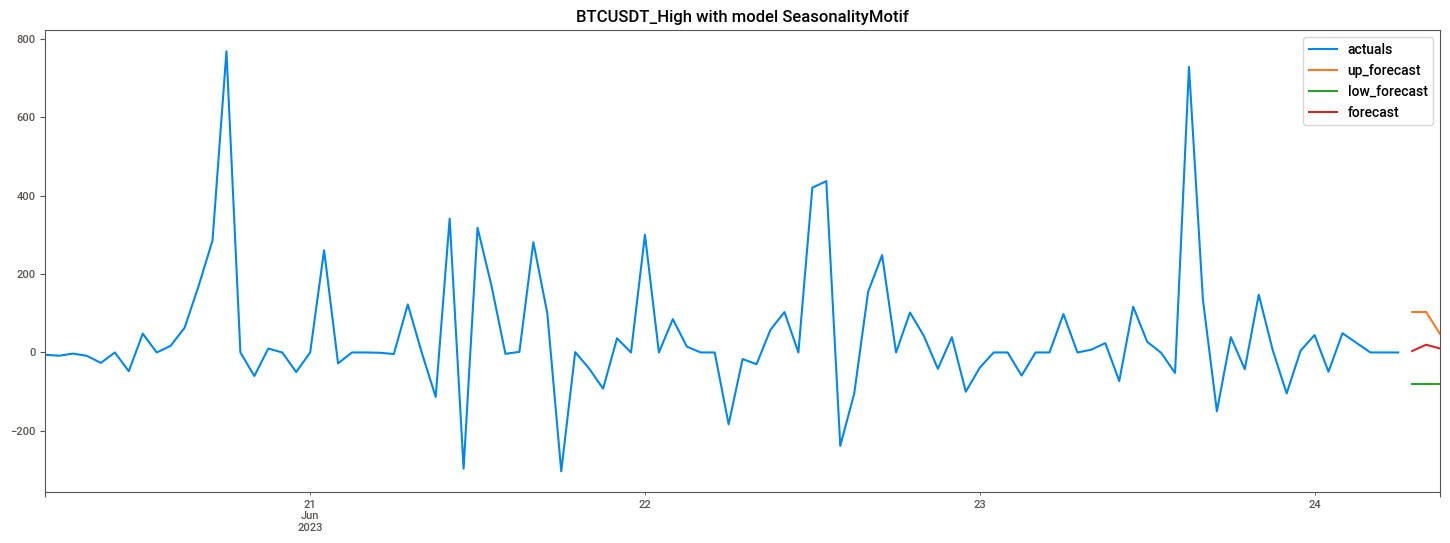

In [ ]:
# plot a sample
prediction_High.plot(model_High.df_wide_numeric,
                series=model_High.df_wide_numeric.columns[0],
                start_date="2023-05-04",
                figsize=(18, 6))

<Axes: title={'center': 'BTCUSDT_Low with model MultivariateMotif'}>

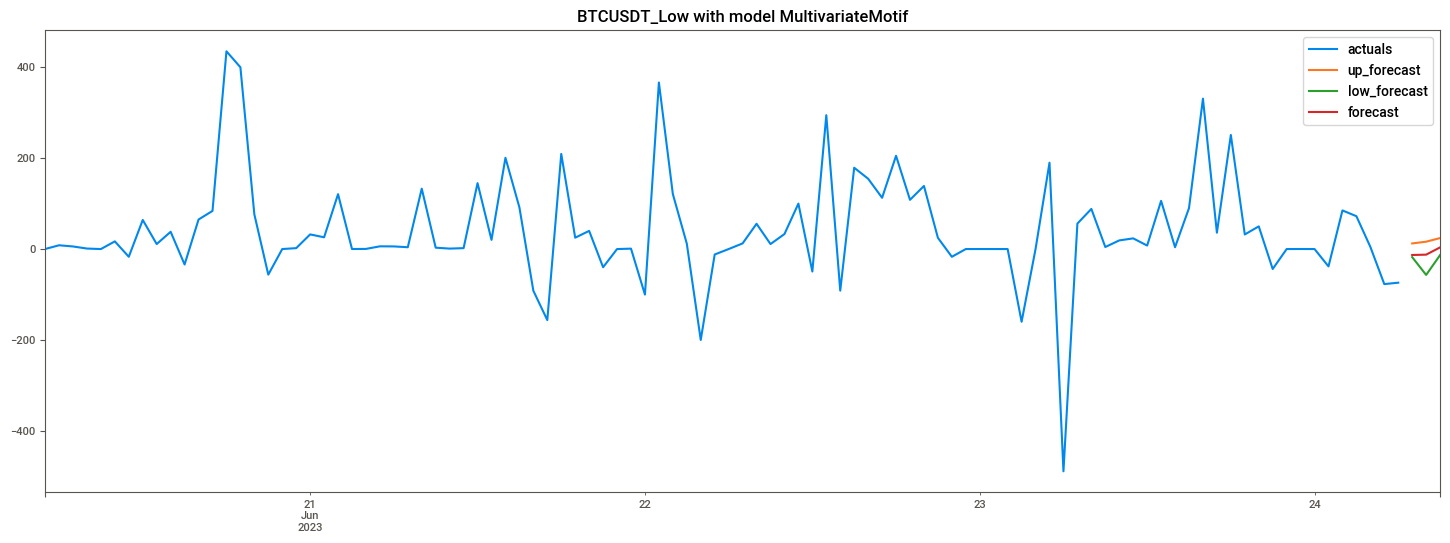

In [ ]:
# plot a sample
prediction_Low.plot(model_Low.df_wide_numeric,
                series=model_Low.df_wide_numeric.columns[0],
                start_date="2023-05-04",
                figsize=(18, 6))

In [ ]:
# upper and lower forecasts
forecasts_High_up, forecasts_High_low = prediction_High.upper_forecast, prediction_High.lower_forecast
print("Максимальное значение предикта",forecasts_High_up)
print("Миниимальное значение предикта",forecasts_High_low)

Максимальное значение предикта                      BTCUSDT_High
2023-06-24 07:00:00    103.120629
2023-06-24 08:00:00    103.120705
2023-06-24 09:00:00     46.930599
Миниимальное значение предикта                      BTCUSDT_High
2023-06-24 07:00:00    -79.579420
2023-06-24 08:00:00    -79.579344
2023-06-24 09:00:00    -79.579268


In [ ]:
# accuracy of all tried model results
model_High.results()

,ID,Model,ModelParameters,TransformationParameters,Ensemble,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Exceptions,...,contour_weighted,maxe_weighted,oda_weighted,dwae_weighted,mqae_weighted,ewmae_weighted,uwmse_weighted,smoothness_weighted,TotalRuntimeSeconds,Score
0,2887d2af24ace64615ccf0154ef2e4be,AverageValueNaive,"{""method"": ""Mean""}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0,0 days 00:00:00,0 days 00:00:00.251950,0 days 00:00:00,0 days 00:00:00.251950,Exception('Transformer SinTrend failed on fit'),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2520,NaN
1,fc1db38e12a38fd77c48db8ba84a1910,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0,0 days 00:00:00.033609,0 days 00:00:00.000580,0 days 00:00:00.003598,0 days 00:00:00.048040,NaN,...,0.666667,28.672175,0.000000,2.474021,26.636087,133.018690,51.844346,0.000000,0.0480,112098.690623
2,d8bd60351c03557d2b76a1f72be762ff,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""rolling_mean_24"", ""transformations...",0,0 days 00:00:00.024443,0 days 00:00:00.000542,0 days 00:00:00.001272,0 days 00:00:00.042204,NaN,...,0.666667,130.969968,0.000000,7.448384,55.431506,525.770926,340.480996,3.232930,0.0422,338349.711020
3,bbb295fbced8e9c0500d85680264e092,DatepartRegression,"{""regression_model"": {""model"": ""DecisionTree"",...","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0,0 days 00:00:00.077366,0 days 00:00:00,0 days 00:00:00.039971,0 days 00:00:00.142805,NaN,...,0.666667,93.331601,0.000000,5.517372,45.318919,378.704672,216.019626,3.379480,0.1428,258236.233560
4,da72751dc1cbf6d2291cb3fd8634c00a,DatepartRegression,"{""regression_model"": {""model"": ""SVM"", ""model_p...","{""fillna"": ""zero"", ""transformations"": {""0"": ""C...",0,0 days 00:00:00.068658,0 days 00:00:00,0 days 00:00:00.026932,0 days 00:00:00.120576,NaN,...,1.000000,3.492482,1.000000,1.006888,1.283903,13.975400,0.198744,0.087061,0.1206,9783.326384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,9711666e20384d3c916f071b22e6ebf6,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""pchip"", ""transformations"": {""0"": ""...",0,0 days 00:00:00.011516,0 days 00:00:00.000014,0 days 00:00:00.011076,0 days 00:00:00.027487,NaN,...,0.666667,110.900063,0.333333,5.319783,19.899969,165.758148,700.199700,0.000000,0.0275,300019.197349
729,f193ad691b71544217974b144f422f7b,MultivariateMotif,"{""window"": 14, ""point_method"": ""weighted_mean""...","{""fillna"": ""rolling_mean"", ""transformations"": ...",0,0 days 00:00:00.009354,0 days 00:00:00.000026,0 days 00:00:00.001955,0 days 00:00:00.016996,NaN,...,0.000000,167.561232,0.333333,8.296301,26.407976,116.064659,1558.414034,0.915334,0.0170,425533.206886
730,68c04ac5d014d2c9ddc22ba5e5d2aed8,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""pchip"", ""transformations"": {""0"": ""...",0,0 days 00:00:00.032105,0 days 00:00:00.000021,0 days 00:00:00.014067,0 days 00:00:00.050457,NaN,...,0.666667,110.900142,0.333333,5.319787,19.899929,165.757552,700.200419,0.000000,0.0505,302524.345284
731,d00ff74972f7ca676d8c8c4e064ed520,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,0 days 00:00:00.006469,0 days 00:00:00.000019,0 days 00:00:00.019355,0 days 00:00:00.031591,NaN,...,0.333333,110.900000,0.666667,2.112403,19.900000,165.758624,700.199126,0.000000,0.0316,303271.030123


In [ ]:
# and aggregated from cross validation
model_High.results("model_weights")

,ID,Model,ModelParameters,TransformationParameters,Ensemble,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Exceptions,...,contour_weighted,maxe_weighted,oda_weighted,dwae_weighted,mqae_weighted,ewmae_weighted,uwmse_weighted,smoothness_weighted,TotalRuntimeSeconds,Score
0,2887d2af24ace64615ccf0154ef2e4be,AverageValueNaive,"{""method"": ""Mean""}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0,0 days 00:00:00,0 days 00:00:00.251950,0 days 00:00:00,0 days 00:00:00.251950,Exception('Transformer SinTrend failed on fit'),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2520,NaN
1,fc1db38e12a38fd77c48db8ba84a1910,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0,0 days 00:00:00.033609,0 days 00:00:00.000580,0 days 00:00:00.003598,0 days 00:00:00.048040,NaN,...,0.666667,28.672175,0.000000,2.474021,26.636087,133.018690,51.844346,0.000000,0.0480,112098.690623
2,d8bd60351c03557d2b76a1f72be762ff,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""rolling_mean_24"", ""transformations...",0,0 days 00:00:00.024443,0 days 00:00:00.000542,0 days 00:00:00.001272,0 days 00:00:00.042204,NaN,...,0.666667,130.969968,0.000000,7.448384,55.431506,525.770926,340.480996,3.232930,0.0422,338349.711020
3,bbb295fbced8e9c0500d85680264e092,DatepartRegression,"{""regression_model"": {""model"": ""DecisionTree"",...","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0,0 days 00:00:00.077366,0 days 00:00:00,0 days 00:00:00.039971,0 days 00:00:00.142805,NaN,...,0.666667,93.331601,0.000000,5.517372,45.318919,378.704672,216.019626,3.379480,0.1428,258236.233560
4,da72751dc1cbf6d2291cb3fd8634c00a,DatepartRegression,"{""regression_model"": {""model"": ""SVM"", ""model_p...","{""fillna"": ""zero"", ""transformations"": {""0"": ""C...",0,0 days 00:00:00.068658,0 days 00:00:00,0 days 00:00:00.026932,0 days 00:00:00.120576,NaN,...,1.000000,3.492482,1.000000,1.006888,1.283903,13.975400,0.198744,0.087061,0.1206,9783.326384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,9711666e20384d3c916f071b22e6ebf6,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""pchip"", ""transformations"": {""0"": ""...",0,0 days 00:00:00.011516,0 days 00:00:00.000014,0 days 00:00:00.011076,0 days 00:00:00.027487,NaN,...,0.666667,110.900063,0.333333,5.319783,19.899969,165.758148,700.199700,0.000000,0.0275,300019.197349
729,f193ad691b71544217974b144f422f7b,MultivariateMotif,"{""window"": 14, ""point_method"": ""weighted_mean""...","{""fillna"": ""rolling_mean"", ""transformations"": ...",0,0 days 00:00:00.009354,0 days 00:00:00.000026,0 days 00:00:00.001955,0 days 00:00:00.016996,NaN,...,0.000000,167.561232,0.333333,8.296301,26.407976,116.064659,1558.414034,0.915334,0.0170,425533.206886
730,68c04ac5d014d2c9ddc22ba5e5d2aed8,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""pchip"", ""transformations"": {""0"": ""...",0,0 days 00:00:00.032105,0 days 00:00:00.000021,0 days 00:00:00.014067,0 days 00:00:00.050457,NaN,...,0.666667,110.900142,0.333333,5.319787,19.899929,165.757552,700.200419,0.000000,0.0505,302524.345284
731,d00ff74972f7ca676d8c8c4e064ed520,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,0 days 00:00:00.006469,0 days 00:00:00.000019,0 days 00:00:00.019355,0 days 00:00:00.031591,NaN,...,0.333333,110.900000,0.666667,2.112403,19.900000,165.758624,700.199126,0.000000,0.0316,303271.030123


In [ ]:
# Обратное дифференцирование значений
restored_forecasts = forecast_High.cumsum() + combined_df['BTCUSDT_High'].iloc[-1]

# Вывод восстановленных значений
print(restored_forecasts)

                     BTCUSDT_High
2023-06-24 07:00:00  30761.713106
2023-06-24 08:00:00  30781.438504
2023-06-24 09:00:00  30791.451412


In [ ]:
model_High.best_model_name

'SeasonalityMotif'

In [ ]:
model_High.best_model_params

{'window': 50,
 'point_method': 'midhinge',
 'distance_metric': 'mse',
 'k': 10,
 'datepart_method': 'expanded_binarized'}

In [ ]:
model_High.best_model_transformation_params

{'fillna': 'pchip',
 'transformations': {'0': 'ClipOutliers',
  '1': 'Detrend',
  '2': 'AnomalyRemoval',
  '3': 'Detrend'},
 'transformation_params': {'0': {'method': 'clip',
   'std_threshold': 3.5,
   'fillna': None},
  '1': {'model': 'GLS',
   'phi': 1,
   'window': None,
   'transform_dict': {'fillna': None,
    'transformations': {'0': 'EWMAFilter'},
    'transformation_params': {'0': {'span': 7}}}},
  '2': {'method': 'zscore',
   'method_params': {'distribution': 'gamma', 'alpha': 0.05},
   'fillna': 'fake_date',
   'transform_dict': {'transformations': {'0': 'DifferencedTransformer'},
    'transformation_params': {'0': {}}}},
  '3': {'model': 'GLS',
   'phi': 1,
   'window': None,
   'transform_dict': {'fillna': 'fake_date',
    'transformations': {'0': 'AlignLastValue', '1': 'AnomalyRemoval'},
    'transformation_params': {'0': {'rows': 1,
      'lag': 1,
      'method': 'additive',
      'strength': 1.0,
      'first_value_only': False},
     '1': {'method': 'zscore',
      'm

In [ ]:
import pickle

# Сохранение обученной модели с использованием pickle
with open('/content/drive/MyDrive/Mihail_treid/pythonProject/AUTOTS_BTCUSDTHigth_Atrained_model.pkl', 'wb') as f:
    pickle.dump(model_High, f)
# Вывод сообщения об успешном сохранении
print("Обученная модель успешно сохранена.")

Обученная модель успешно сохранена.


In [ ]:
# Загрузка модели из файла
with open('/content/drive/MyDrive/Mihail_treid/pythonProject/AUTOTS_BTCUSDTHigth_Atrained_model.pkl', 'rb') as f:
    loaded_model_High = pickle.load(f)
# Вывод сообщения об успешной загрузке
print("Модель успешно загружена.")

Модель успешно загружена.


In [ ]:
value = np.add(forecast_High['BTCUSDT_High'], forecast_Low['BTCUSDT_Low'])
trend_direction = np.where(value > 10, 2, np.where(value < -10, 1, 0))
print(value)

2023-06-24 07:00:00    -9.349506
2023-06-24 08:00:00     7.402757
2023-06-24 09:00:00    13.684670
Freq: H, dtype: float64


In [ ]:
def get_trend_direction(forecast_High, forecast_Low):
    value = np.add(forecast_High['BTCUSDT_High'], forecast_Low['BTCUSDT_Low'])
    trend_direction = np.where(value > 10, 2, np.where(value < -10, 1, 0))
    return trend_direction


def get_value(trend_direction):
    if np.all(trend_direction == 2):
        return 2
    elif np.any(trend_direction == 1):
        return 1
    elif np.any(trend_direction == 0):
        return 0
    else:
        return 0

In [ ]:
get_trend = get_trend_direction(forecast_High, forecast_Low)
get_trend

array([0, 0, 2])

In [ ]:
get_value(get_trend)

0

In [ ]:

def get_trend_direction(forecast_High, forecast_Low):
    trend_direction_High = np.where(forecast_High['BTCUSDT_High'] > 10, 2, np.where(forecast_High['BTCUSDT_High'] < -10, 1, 0))
    trend_direction_Low = np.where(forecast_Low['BTCUSDT_Low'] > 10, 2, np.where(forecast_Low['BTCUSDT_Low'] < -10, 1, 0))
    combined_trend_direction = np.concatenate((trend_direction_High, trend_direction_Low))
    print(combined_trend_direction)
    return combined_trend_direction

trend_direction_High = get_trend_direction(forecast_High, forecast_Low)

[0 2 2 1 1 0]
